<a href="https://colab.research.google.com/github/alucinationx/Cripto_Modelling/blob/main/modelolstmteste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install -r requirements.txt

In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [12]:
#Variables

np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
target_col = 'close'

In [2]:
def get_cripto_price(coin1, coin2, limit):
    '''
    Download data from the cryptocompare api

    Keyword Arguments:\t
    coin1: Coin to compare price to coin 2\t
    coin2: Coin to compare price to coin 1\t
    limit: Limit of values returned. Maximum of 2000.
    '''  
    endpoint = 'https://min-api.cryptocompare.com/data/histoday'
    res = requests.get(endpoint + '?fsym=' + coin1 + '&tsym=' + coin2 + '&limit=' + limit)
    hist = pd.DataFrame(json.loads(res.content)['Data'])
    hist = hist.set_index('time')
    hist.index = pd.to_datetime(hist.index, unit='s')
    pair = coin1 + '-' + coin2
    return hist, pair

In [3]:
hist, pair = get_cripto_price('ADA','USD','500')
hist.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2020-01-31,0.05650,0.05227,0.05607,8940698.59,485390.54,0.05383,direct,
2020-02-01,0.05708,0.05322,0.05383,5130318.10,282630.11,0.05612,direct,
2020-02-02,0.05871,0.05492,0.05612,8531715.80,489070.90,0.05578,direct,
2020-02-03,0.05795,0.05533,0.05578,5773863.62,327418.30,0.05704,direct,
2020-02-04,0.05770,0.05421,0.05704,7516294.49,419354.46,0.05607,direct,


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.2)

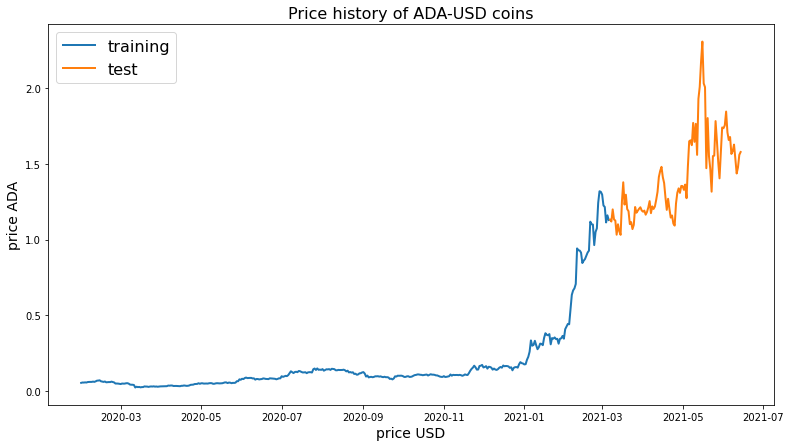

In [13]:
def line_plot(line1, line2, label1=None, label2=None, pair=pair, lw=2):
    coin1 = pair.split('-')[0]
    coin2 = pair.split('-')[1]
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price ' + coin1, fontsize=14)
    ax.set_xlabel('price ' + coin2, fontsize=14)
    ax.set_title('Price history of ' + pair + ' coins', fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(line1=train[target_col], line2=test[target_col], label1='training', label2='test', pair=pair)

In [6]:
def normalise_zero_base(df):
    '''
    Get the first five columns (where we have numbers) and divide by the first row
    '''
    return df.iloc[:,:5] / df.to_numpy()[0,:5] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [7]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [8]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [9]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [14]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)